# Visualization of Numerical Experiments (1): Comparison of SAA and DRO on Tracking Model

We start by loading the dependencies.

In [1]:
import sys
import os
import re
import glob
import datetime as dt
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mosek.fusion import *
from tqdm import tqdm
import time
import scipy.stats as sps
import re
from scipy.interpolate import interp1d
import math

# Import new models
from EITP.Models.TrackingModelSAA import TrackingModelSAA as TrackingModelSAA;
from EITP.Models.TrackingModelDRO import TrackingModelDRO as TrackingModelDRO;

# Import statistics packages
from EITP.Backtesting.VisualComparison import Visualizer;
from EITP.Backtesting.QuantitativeComparison import PerformanceMetrics;
from EITP.PerformanceEvaluation.QuantitativeStatistics import PerformanceMetrics;

# Experiment 1 (Sensitivity to Wasserstein Radius)

Then we can load the desired data set from the experiments.

In [2]:
# Save training sizes as list for recovery
rho = 0.3
beta = 0.8
trainingSizes = [63, 126, 189, 252]
aux = "_".join(str(e) for e in trainingSizes)
nSim = 200
nEps = 50
nTS = len(trainingSizes)
nRecords = 16
epsCollection = 10**np.linspace(-3, 1, nEps)
nAssets = 313

# Load weights
Weights_vs_Wasserstein = np.loadtxt("./Results/WassersteinWeights_T_{}_P_{}_{}_S_{}_recover_{}_{}_{}.csv".format(aux, 
                                                                            beta, 
                                                                            rho, 
                                                                            nSim,
                                                                            len(trainingSizes), 
                                                                            nEps, 
                                                                            nAssets), delimiter=' ')                

Weights_vs_Wasserstein = Weights_vs_Wasserstein.reshape((nTS, nEps, nAssets))

# Specify columns
columns =    ['WassersteinRadius',
             'Objective',
             'DownsideSemiStandardDeviation',
             'RMSE',
             'MAD',
             'VaR-{}'.format(beta),
             'CVaR-{}'.format(beta),
             'ExcessReturnAverage',
             'ExcessReturn',
             'SortinoIndex',
             'BeatBenchmarkRatio',
             'TotalReturn',
             'AverageReturn',
             'P5',
             'P10',
             'P90',
             'P95']

# In-Sample
IS_statistics = np.loadtxt("./Results/TrackerModelDRO_IS_statistics_T_{}_P_{}_{}_S_{}_recover_{}_{}_{}_{}.csv".format(aux, 
                                                                                                      beta, 
                                                                                                      rho, 
                                                                                                      nSim, 
                                                                                                      nTS, nSim, nEps, nRecords), delimiter=' ')
IS_statistics = IS_statistics.reshape((nTS,nSim,nEps,nRecords))

# Out-of-Sample
OoS_statistics = np.loadtxt("./Results/TrackerModelDRO_OoS_statistics_T_{}_P_{}_{}_S_{}_recover_{}_{}_{}_{}.csv".format(aux, 
                                                                                                      beta, 
                                                                                                      rho, 
                                                                                                      nSim, 
                                                                                                      nTS, nSim, nEps, nRecords), delimiter=' ')
OoS_statistics = OoS_statistics.reshape((nTS,nSim,nEps,nRecords))

## Plot 1: Weights

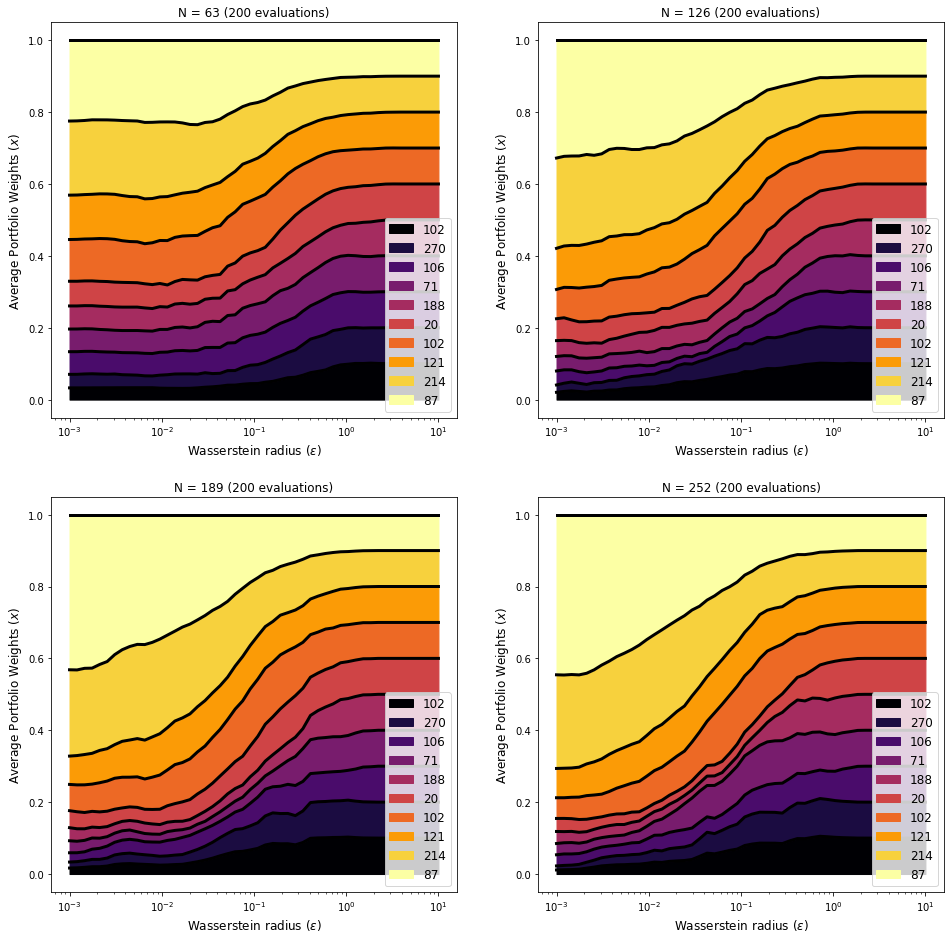

In [3]:
np.random.seed(42)

subset_selector = np.random.randint(0, high=Weights_vs_Wasserstein.shape[2], size=10)
assetNames = np.array(subset_selector, dtype=str)
myMap = plt.get_cmap('inferno') # Paired, inferno
colors = myMap(np.linspace(0,1,len(assetNames)))

# Plot the weights
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

for j in range(2):
    
    # Compute average weights (and select random subset)
    trainingSize = trainingSizes[j]
    Avg_w = Weights_vs_Wasserstein[j,:,:]/nSim
    sort_indices = np.argsort(Avg_w[0,subset_selector])
    subset_selector = subset_selector[sort_indices]
    Avg_w_subset = Avg_w[:,subset_selector]

    # Normalize weights to sum to 1
    for i in range(Avg_w_subset.shape[0]):
        Avg_w_subset[i,:] = Avg_w_subset[i,:]/sum(Avg_w_subset[i,:])

    # Average weights
    wCumSum = np.cumsum(Avg_w_subset, axis=1)    

    # Plot the result
    ax[0,j].plot(epsCollection, wCumSum, color='black', linewidth=3)
    ax[0,j].fill_between(epsCollection, wCumSum[:,0], color=colors[0,:], label=assetNames[0])
    for i in range(1,len(subset_selector)):
        ax[0,j].fill_between(epsCollection, wCumSum[:,i-1], wCumSum[:,i], color=colors[i,:], label=assetNames[i])
    ax[0,j].set_xlabel(r'Wasserstein radius ($\epsilon$)', fontsize=12)
    ax[0,j].set_ylabel(r'Average Portfolio Weights ($x$)', fontsize=12)
    ax[0,j].legend(loc="lower right", facecolor="white", fontsize=12)
    ax[0,j].set_xscale('log')
    ax[0,j].set_title(r'N = {} ({} evaluations)'.format(trainingSizes[j], nSim))
    
for j in range(2):
    
    # Compute average weights (and select random subset)
    trainingSize = trainingSizes[j+2]
    Avg_w = Weights_vs_Wasserstein[j+2,:,:]/nSim
    sort_indices = np.argsort(Avg_w[0,subset_selector])
    subset_selector = subset_selector[sort_indices]
    Avg_w_subset = Avg_w[:,subset_selector]

    # Normalize weights to sum to 1
    for i in range(Avg_w_subset.shape[0]):
        Avg_w_subset[i,:] = Avg_w_subset[i,:]/sum(Avg_w_subset[i,:])

    # Average weights
    wCumSum = np.cumsum(Avg_w_subset, axis=1)    

    # Plot the result
    ax[1,j].plot(epsCollection, wCumSum, color='black', linewidth=3)
    ax[1,j].fill_between(epsCollection, wCumSum[:,0], color=colors[0,:], label=assetNames[0])
    for i in range(1,len(subset_selector)):
        ax[1,j].fill_between(epsCollection, wCumSum[:,i-1], wCumSum[:,i], color=colors[i,:], label=assetNames[i])
    ax[1,j].set_xlabel(r'Wasserstein radius ($\epsilon$)', fontsize=12)
    ax[1,j].set_ylabel(r'Average Portfolio Weights ($x$)', fontsize=12)
    ax[1,j].legend(loc="lower right", facecolor="white", fontsize=12)
    ax[1,j].set_xscale('log')
    ax[1,j].set_title(r'N = {} ({} evaluations)'.format(trainingSizes[j+2], nSim))

# Save figure
plt.savefig('./ResultsPlots/TRACKING_Fig1_WassersteinWeights_{}_{}_P_{}_{}.png'.format(nSim, nEps, rho, beta), dpi=200)

# Show figure
plt.show()

## Plot 2: Dispersion in Weights

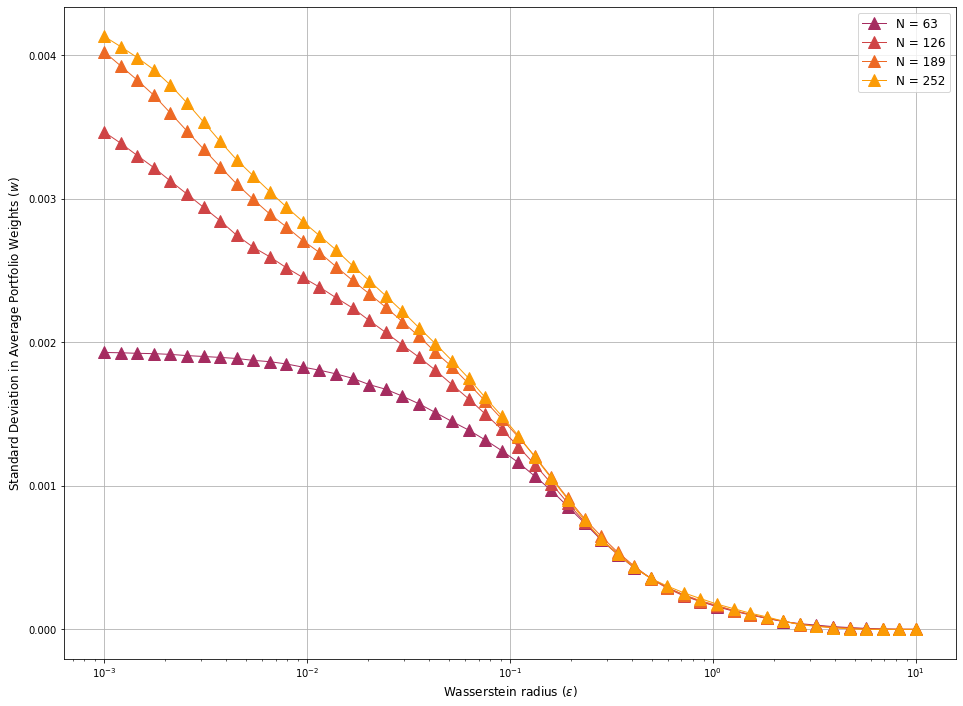

In [4]:
# Specify colors
myMap = plt.get_cmap('inferno') # Paired, inferno
colors = myMap(np.linspace(0,1,len(assetNames)))

# Plot the weights
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 12))

# Now construct the plot
for j in range(Weights_vs_Wasserstein.shape[0]):
    Avg_w = Weights_vs_Wasserstein[j,:,:]/nSim
    ax.plot(epsCollection, np.std(Avg_w, axis=1), marker="^", label="N = {}".format(trainingSizes[j]), markersize=12, color=colors[4+j,:], linewidth=1)
    
ax.set_xlabel(r'Wasserstein radius ($\epsilon$)', fontsize=12)
ax.set_ylabel(r'Standard Deviation in Average Portfolio Weights ($w$)', fontsize=12)
ax.set_xscale('log')
ax.legend(fontsize=12)
ax.grid()

# Save figure
plt.savefig('./ResultsPlots/TRACKING_Fig2_WassersteinWeightsDeviation_{}_{}_P_{}_{}.png'.format(nSim, nEps, rho, beta), dpi=200)

# Show figure
plt.show()

## Plot 3: Out-of-Sample Performance and Reliability

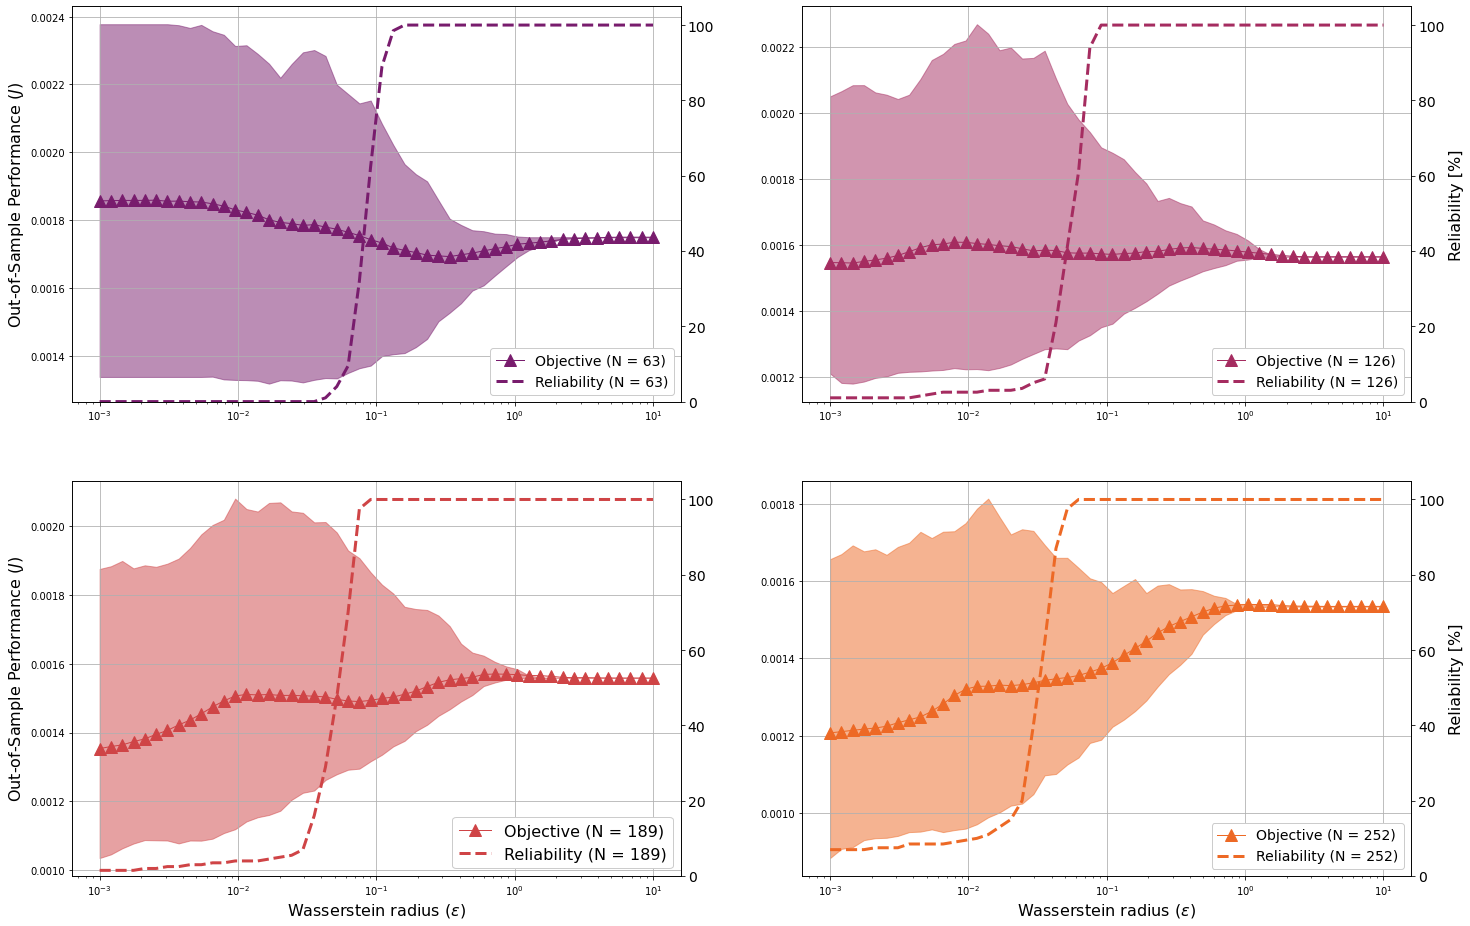

In [5]:
# Specify colors
myMap = plt.get_cmap('inferno') # Paired, inferno
colors = myMap(np.linspace(0,1,len(assetNames)))

# Plot the weights
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24, 16))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

# --------- First plot ---------

colorChoice = 3
colorChoiceRel = 3

# Now construct the out-of-sample plot
meanJ = np.mean(OoS_statistics[0,:,:,0].T, axis=1)
P80J = np.quantile(OoS_statistics[0,:,:,0].T, 0.80, axis=1)
P20J = np.quantile(OoS_statistics[0,:,:,0].T, 0.20, axis=1)
ax[0,0].plot(epsCollection, meanJ, 
            marker="^", markersize=12, color=colors[colorChoice,:], linewidth=1, label="Objective (N = {})".format(trainingSizes[0]))
ax[0,0].fill_between(epsCollection, P20J, P80J, color=colors[colorChoice,:], alpha=0.5)
#ax[0,0].set_xlabel(r'Wasserstein radius ($\epsilon$)', fontsize=12)
ax[0,0].set_ylabel(r'Out-of-Sample Performance ($J$)', fontsize=16)
ax[0,0].set_xscale('log')
ax[0,0].grid()

# Construct the reliability plot
ax00 = ax[0,0].twinx()
relMatrix = OoS_statistics[0,:,:,0] < IS_statistics[0,:,:,0]
totalSim = OoS_statistics[0,:,:,0].shape[0]
reliabibility = (np.sum(relMatrix, axis=0)/totalSim)*100
ax00.plot(epsCollection, reliabibility, color=colors[colorChoiceRel,:], linewidth=3, linestyle="--", label="Reliability (N = {})".format(trainingSizes[0]))
#ax00.set_ylabel('Reliability [%]', color='black')
ax00.set_yticks(np.arange(0, 120, 20))
ax00.set_ylim(0, 105)

# Construct legends
lines, labels = ax[0,0].get_legend_handles_labels()
lines2, labels2 = ax00.get_legend_handles_labels()
ax00.legend(lines + lines2, labels + labels2, fontsize=14, framealpha=1, facecolor='white', loc='lower right')


# --------- Second plot ---------

colorChoice = 4
colorChoiceRel = 4

# Now construct the out-of-sample plot
meanJ = np.mean(OoS_statistics[1,:,:,0].T, axis=1)
P80J = np.quantile(OoS_statistics[1,:,:,0].T, 0.80, axis=1)
P20J = np.quantile(OoS_statistics[1,:,:,0].T, 0.20, axis=1)
ax[0,1].plot(epsCollection, meanJ, 
            marker="^", markersize=12, color=colors[colorChoice,:], linewidth=1, label="Objective (N = {})".format(trainingSizes[1]))
ax[0,1].fill_between(epsCollection, P20J, P80J, color=colors[colorChoice,:], alpha=0.5)
#ax[0,1].set_xlabel(r'Wasserstein radius ($\epsilon$)', fontsize=12)
#ax[0,1].set_ylabel(r'Out-of-Sample Performance ($J$)', fontsize=12)
ax[0,1].set_xscale('log')
ax[0,1].grid()

# Construct the reliability plot
ax01 = ax[0,1].twinx()
relMatrix = OoS_statistics[1,:,:,0] < IS_statistics[1,:,:,0]
totalSim = OoS_statistics[1,:,:,0].shape[0]
reliabibility = (np.sum(relMatrix, axis=0)/totalSim)*100
ax01.plot(epsCollection, reliabibility, color=colors[colorChoiceRel,:], linewidth=3, linestyle="--", label="Reliability (N = {})".format(trainingSizes[1]))
ax01.set_ylabel('Reliability [%]', color='black', fontsize=16)
ax01.set_yticks(np.arange(0, 120, 20))
ax01.set_ylim(0, 105)

# Construct legends
lines, labels = ax[0,1].get_legend_handles_labels()
lines2, labels2 = ax01.get_legend_handles_labels()
ax01.legend(lines + lines2, labels + labels2, fontsize=14, framealpha=1, facecolor='white', loc='lower right')

# --------- Third plot ---------

colorChoice = 5
colorChoiceRel = 5

# Now construct the out-of-sample plot
meanJ = np.mean(OoS_statistics[2,:,:,0].T, axis=1)
P80J = np.quantile(OoS_statistics[2,:,:,0].T, 0.80, axis=1)
P20J = np.quantile(OoS_statistics[2,:,:,0].T, 0.20, axis=1)
ax[1,0].plot(epsCollection, meanJ, 
            marker="^", markersize=12, color=colors[colorChoice,:], linewidth=1, label="Objective (N = {})".format(trainingSizes[2]))
ax[1,0].fill_between(epsCollection, P20J, P80J, color=colors[colorChoice,:], alpha=0.5)
ax[1,0].set_xlabel(r'Wasserstein radius ($\epsilon$)', fontsize=16)
ax[1,0].set_ylabel(r'Out-of-Sample Performance ($J$)', fontsize=16)
ax[1,0].set_xscale('log')
ax[1,0].grid()

# Construct the reliability plot
ax10 = ax[1,0].twinx()
relMatrix = OoS_statistics[2,:,:,0] < IS_statistics[1,:,:,0]
totalSim = OoS_statistics[2,:,:,0].shape[0]
reliabibility = (np.sum(relMatrix, axis=0)/totalSim)*100
ax10.plot(epsCollection, reliabibility, color=colors[colorChoiceRel,:], linewidth=3, linestyle="--", label="Reliability (N = {})".format(trainingSizes[2]))
#ax10.set_ylabel('Reliability [%]', color='black')
ax10.set_yticks(np.arange(0, 120, 20))
ax10.set_ylim(0, 105)

# Construct legends
lines, labels = ax[1,0].get_legend_handles_labels()
lines2, labels2 = ax10.get_legend_handles_labels()
ax10.legend(lines + lines2, labels + labels2, fontsize=16, framealpha=1, facecolor='white', loc='lower right')

# --------- Fourth plot ---------

colorChoice = 6
colorChoiceRel = 6

# Now construct the out-of-sample plot
meanJ = np.mean(OoS_statistics[3,:,:,0].T, axis=1)
P80J = np.quantile(OoS_statistics[3,:,:,0].T, 0.80, axis=1)
P20J = np.quantile(OoS_statistics[3,:,:,0].T, 0.20, axis=1)
ax[1,1].plot(epsCollection, meanJ, 
            marker="^", markersize=12, color=colors[colorChoice,:], linewidth=1, label="Objective (N = {})".format(trainingSizes[3]))
ax[1,1].fill_between(epsCollection, P20J, P80J, color=colors[colorChoice,:], alpha=0.5)
ax[1,1].set_xlabel(r'Wasserstein radius ($\epsilon$)', fontsize=16)
#ax[1,1].set_ylabel(r'Out-of-Sample Performance ($J$)', fontsize=12)
ax[1,1].set_xscale('log')
ax[1,1].grid()

# Construct the reliability plot
ax11 = ax[1,1].twinx()
relMatrix = OoS_statistics[3,:,:,0] < IS_statistics[3,:,:,0]
totalSim = OoS_statistics[3,:,:,0].shape[0]
reliabibility = (np.sum(relMatrix, axis=0)/totalSim)*100
ax11.plot(epsCollection, reliabibility, color=colors[colorChoiceRel,:], linewidth=3, linestyle="--", label="Reliability (N = {})".format(trainingSizes[3]))
ax11.set_ylabel('Reliability [%]', color='black', fontsize=16)
ax11.set_yticks(np.arange(0, 120, 20))
ax11.set_ylim(0, 105)

# Construct legends
lines, labels = ax[1,1].get_legend_handles_labels()
lines2, labels2 = ax11.get_legend_handles_labels()
ax11.legend(lines + lines2, labels + labels2, fontsize=14, framealpha=1, facecolor='white', loc='lower right')

# Save figure
plt.savefig('./ResultsPlots/TRACKING_Fig3_OoS_Reliability_{}_{}_P_{}_{}.png'.format(nSim, nEps, rho, beta), dpi=200)

# Show figure
plt.show()

# Experiment 2 (Sensitivity to Choice of Historical Samples)

We start by loading the data. See the corresponding experiment file to see the specific model parameters.

In [13]:
# Save training sizes as list for recovery
trainingSizes = np.array(21*np.linspace(2,18,8), dtype=np.int32) 
nSim = 200
nTS = len(trainingSizes)
nModels = 2

# Load certificates
Certificate = np.loadtxt("./Results/Experiment2_TrackerModelDRO_Certificate_recover_{}_{}_{}.csv".format(nModels,nTS,nSim),
                         delimiter=' ').reshape((nModels, nSim, nTS))           

# Load out-of-sample performance
J = np.loadtxt("./Results/Experiment2_TrackerModelDRO_J_recover_{}_{}_{}.csv".format(nModels,nTS,nSim),
                         delimiter=' ').reshape((nModels, nSim, nTS))

# Load optimal Wasserstein radii
epsOpt = np.loadtxt("./Results/Experiment2_TrackerModelDRO_epsOpt_recover_{}_{}.csv".format(nTS,nSim),
                         delimiter=' ').reshape((nSim, nTS))

Then we can recreate the plot from Kuhn 2015.

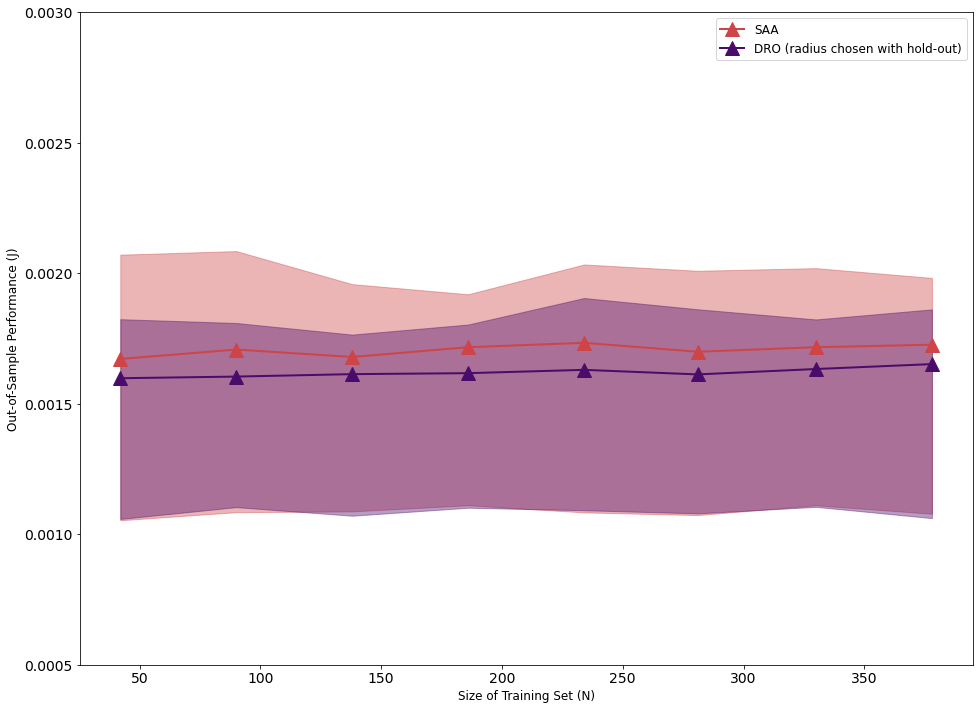

In [33]:
# Specify colors
myMap = plt.get_cmap('inferno') # Paired, inferno
colors = myMap(np.linspace(0,1,10))

# Set colors from the scale used for plotting the weights
colorDRO = colors[2]
colorSAA = colors[5]

# Control the width of the confidence intervals
lower = 0.25
upper = 0.75

# Prepare plots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 12))

# Plot the OoS-performance
J_SAA = J[0,:,:]
ax.plot(trainingSizes, np.mean(J_SAA, axis=0), color=colorSAA, linewidth=2, marker="^", markersize=14, label="SAA")
ax.fill_between(trainingSizes, np.quantile(J_SAA, lower, axis=0), np.quantile(J_SAA, upper, axis=0), color=colorSAA, alpha=0.4)
J_DRO = J[1,:,:]
ax.plot(trainingSizes, np.mean(J_DRO, axis=0), color=colorDRO, linewidth=2, marker="^", markersize=14, label="DRO (radius chosen with hold-out)")
ax.fill_between(trainingSizes, np.quantile(J_DRO, lower, axis=0), np.quantile(J_DRO, upper, axis=0), color=colorDRO, alpha=0.4)
ax.set_xlabel(r'Size of Training Set (N)', fontsize=12)
ax.set_ylabel(r'Out-of-Sample Performance (J)', fontsize=12)
ax.legend(loc="best", facecolor="white", fontsize=12)
#ax.set_xscale('log')
ax.set_ylim([0.0005,0.0030])

# Save figure
plt.savefig('./ResultsPlots/TRACKING_Fig4_OoS_TrainingSize_{}_{}_P_{}_{}.png'.format(nTS, nSim, rho, beta), dpi=200)

# Show figure
plt.show()

Then we can show the distribution of the optimal Wasserstein radii.

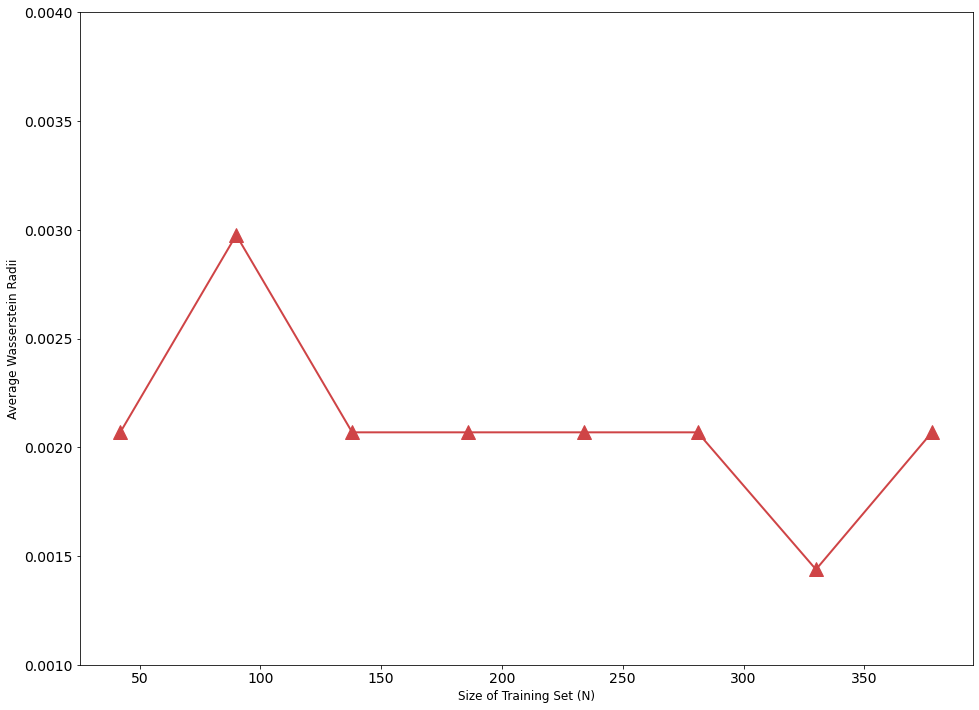

In [34]:
# Specify colors
myMap = plt.get_cmap('inferno') # Paired, inferno
colors = myMap(np.linspace(0,1,10))

# Set colors from the scale used for plotting the weights
colorDRO_epsOpt = colors[5]

# Control the width of the confidence intervals
lower = 0.25
upper = 0.75

# Prepare plots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 12))

# Plot the OoS-performance
ax.plot(trainingSizes, np.quantile(epsOpt, 0.50, axis=0), color=colorDRO_epsOpt, linewidth=2, marker="^", markersize=14)
#ax.fill_between(trainingSizes, np.quantile(epsOpt, lower, axis=0), np.quantile(epsOpt, upper, axis=0), color=colorDRO_epsOpt, alpha=0.4)
ax.set_xlabel(r'Size of Training Set (N)', fontsize=12)
ax.set_ylabel(r'Average Wasserstein Radii', fontsize=12)
#ax.set_xscale('log')
ax.set_ylim([0.001,0.004])

# Save figure
plt.savefig('./ResultsPlots/TRACKING_Fig5_AverageWassersteinRadii_{}_{}_P_{}_{}.png'.format(nTS, nSim, rho, beta), dpi=200)

# Show figure
plt.show()


In [117]:
np.mean(epsOpt, axis=0)

array([0.02380256, 0.02357698])